In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightning

lightning.seed_everything(123456)
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", font_scale=1.2, palette="muted")
plt.rcParams["figure.figsize"] = [12, 4]

%matplotlib inline

Seed set to 123456


In [2]:
from aeon.datasets import load_classification
train_data, train_labels = load_classification("ECG200", split="train", extract_path="/home/ventus/university/data-mining/labs/data/ECG200")
test_data, test_labels = load_classification("ECG200", split="test", extract_path="/home/ventus/university/data-mining/labs/data/ECG200")

train_data = train_data.transpose((0, 2, 1))
test_data = test_data.transpose((0, 2, 1))
train_labels = train_labels.astype(int)%3
test_labels = test_labels.astype(int)%3

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
def eval_classification(train_repr, test_repr):
	svm_classifier = SVC(kernel='linear')
	svm_classifier.fit(train_repr, train_labels)
	y_pred = svm_classifier.predict(test_repr)
	return accuracy_score(test_labels, y_pred)

def fit_predict(train_data, test_data, model, **kwargs):
	model = model(
		input_dims=1,
		output_dims=128,
		**kwargs
	)

	model.fit(train_data, n_epochs=500, verbose=0)
	train_repr = model.encode(train_data, encoding_window='full_series')  # n_instances x output_dims
	test_repr = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims
	return train_repr, test_repr


In [4]:
eval_classification(train_data.squeeze(), test_data.squeeze())

0.82

In [5]:
%%time
from trep import TRep
train_trep, test_trep = fit_predict(train_data, test_data, TRep, time_embedding="t2v_sin")
eval_classification(train_trep, test_trep)

CPU times: user 2min 18s, sys: 726 ms, total: 2min 19s
Wall time: 2min 20s


0.88

In [6]:
%%time
from ts2vec import TS2Vec
train_ts2vec, test_ts2vec = fit_predict(train_data, test_data, TS2Vec)
eval_classification(train_ts2vec, test_ts2vec)

CPU times: user 1min 10s, sys: 150 ms, total: 1min 11s
Wall time: 1min 11s


0.82

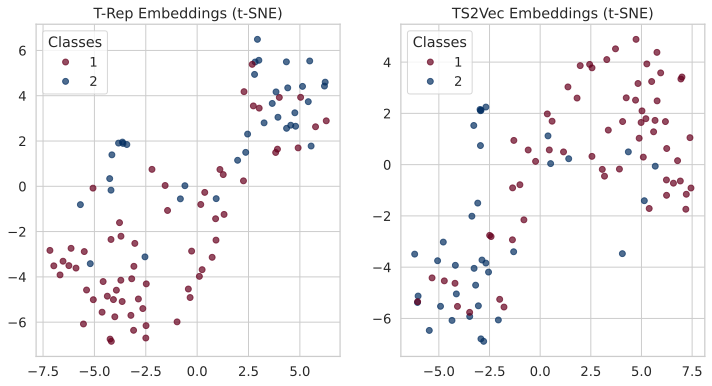

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_embeddings(embeddings, labels, title='', ax=plt):
    reducer = TSNE(n_components=2, random_state=42)
    reduced = reducer.fit_transform(embeddings)

    # plt.figure(figsize=(8, 6))
    scatter = ax.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="RdBu", alpha=0.7)
    ax.legend(*scatter.legend_elements(), title="Classes")
    ax.set_title(title)
    ax.grid(True)
    # plt.show()

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_embeddings(test_trep, test_labels, title='T-Rep Embeddings (t-SNE)', ax=axes[0])
plot_embeddings(test_ts2vec, test_labels, title='TS2Vec Embeddings (t-SNE)', ax=axes[1])


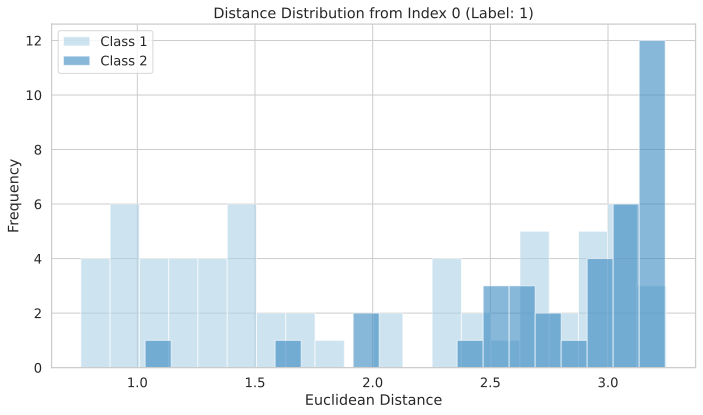

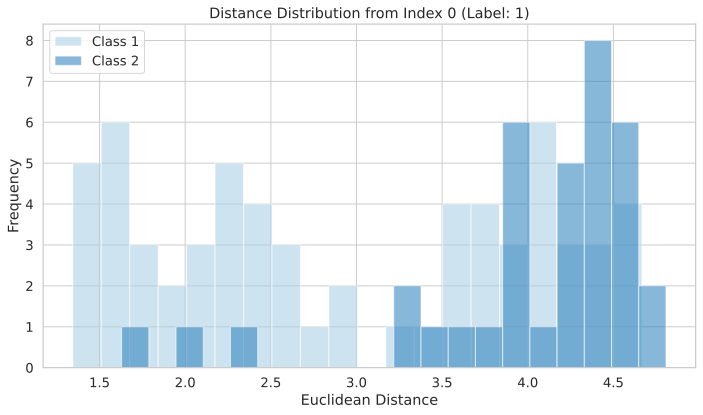

In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distance_histogram(embeddings, labels, idx, metric='cosine', bins=20, figsize=(10, 6)):
    unique_classes = np.unique(labels)
    palette = sns.color_palette("Blues", len(unique_classes))
    class_colors = {cls: palette[i] for i, cls in enumerate(unique_classes)}

    query_embedding = embeddings[idx]
    query_label = labels[idx]

    if metric == 'cosine':
        distances = 1 - cosine_similarity([query_embedding], embeddings)[0]  # cosine distance = 1 - similarity
        xlabel = 'Cosine Distance (1 - similarity)'
    elif metric == 'euclidean':
        distances = np.linalg.norm(embeddings - query_embedding, axis=1)
        xlabel = 'Euclidean Distance'
    else:
        raise ValueError("metric must be 'cosine' or 'euclidean'")

    # Skip distance to self
    distances = distances[np.arange(len(distances)) != idx]
    other_labels = labels[np.arange(len(labels)) != idx]

    # Group distances by class
    class_distances = {cls: [] for cls in unique_classes}
    for d, lbl in zip(distances, other_labels):
        class_distances[lbl].append(d)

    # Plot histogram
    plt.figure(figsize=figsize)
    for cls, dists in class_distances.items():
        plt.hist(dists, bins=bins, alpha=0.6, label=f"Class {cls}", color=class_colors[cls])

    plt.title(f"Distance Distribution from Index {idx} (Label: {query_label})")
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_distance_histogram(test_trep, test_labels, idx=0, metric='euclidean')
plot_distance_histogram(test_ts2vec, test_labels, idx=0, metric='euclidean')



### Masks

In [9]:
def mask_series(series, mask_ratio=0.2):
    masked = series.copy()
    n_mask = int(series.shape[1] * mask_ratio)
    mask_indices = np.random.choice(series.shape[1], n_mask, replace=False)
    masked[:, mask_indices] = 0  # or np.nan, depending on model's support
    return masked

# Mask train_data and re-encode
masked_train_data = mask_series(train_data, mask_ratio=0.3)
masked_test_data = mask_series(test_data, mask_ratio=0.3)

In [10]:
eval_classification(masked_train_data.squeeze(), masked_test_data.squeeze())

0.8

In [13]:
%%time
from trep import TRep
masked_train_trep, masked_test_trep = fit_predict(train_data, test_data, TRep, time_embedding="t2v_sin")
print(cosine_similarity(test_trep, masked_test_trep).diagonal().mean())
eval_classification(masked_train_trep, masked_test_trep)

0.8363127
CPU times: user 2min 17s, sys: 90 ms, total: 2min 17s
Wall time: 2min 18s


0.83

In [15]:
%%time
from ts2vec import TS2Vec
masked_train_ts2vec, masked_test_ts2vec = fit_predict(train_data, test_data, TS2Vec)
print(cosine_similarity(test_ts2vec, masked_test_ts2vec).diagonal().mean())
eval_classification(masked_train_ts2vec, masked_test_ts2vec)

0.8981198
CPU times: user 1min 14s, sys: 84 ms, total: 1min 14s
Wall time: 1min 15s


0.87